In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from time import time

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

seed = None

In [2]:
df = pd.read_csv('dataset/winequality-red.csv')
# df['CITRIC_ACID'] = df['CITRIC_ACID'] * 2

In [3]:
# Parameters
value_to_predict = [7, 8]
cross_validation_size = 0.2
test_size = 0.3
target = 'QUALITY'
columns_to_choose = [
    'FIXED_ACIDITY',
    'VOLATILE_ACIDITY',
    'CITRIC_ACID',
    'RESIDUAL_SUGAR',
    'CHLORIDES',
    'FREE_SULFUR_DIOXIDE',
    'TOTAL_SULFUR_DIOXIDE',
    'DENSITY',
    'pH',
    'SULPHATES',
    'ALCOHOL'
]

'''
Column Rankings:
('ALCOHOL', 1400)
('SULPHATES', 1249)
('VOLATILE_ACIDITY', 1111)
('CITRIC_ACID', 1000)
('TOTAL_SULFUR_DIOXIDE', 769)
('FIXED_ACIDITY', 747)
('CHLORIDES', 542)
('DENSITY', 454)
('RESIDUAL_SUGAR', 209)
('pH', 206)
('FREE_SULFUR_DIOXIDE', 13)]
'''

quality_binarize = [1 if row_quality in value_to_predict else 0 for row_quality in df[target]]
df[target] = quality_binarize

In [4]:
X = df[columns_to_choose]
y = df[target]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = test_size,
                                                    random_state = seed
                                                   )
X_train, X_cross_validation, y_train, y_cross_validation = train_test_split(X_train, y_train,
                                                                            test_size = cross_validation_size,
                                                                            random_state = seed
                                                                           )

In [6]:
train_rate_keep = 1.0
subset_index = np.random.choice(X_train.index,
                                size = int(len(X_train.index) * train_rate_keep),
                                replace = False)

training_set_subset = df.iloc[subset_index]
X_train_subset = training_set_subset[columns_to_choose]
y_train_subset = training_set_subset[target]

In [7]:
positive_cnt = list(y_train_subset).count(1)
k_neighbors = 5 if positive_cnt >= 5 else positive_cnt
# print(k_neighbors)

In [8]:
X_resampled, y_resampled = SMOTE(random_state = seed,
                                 k_neighbors = k_neighbors
                                 ,
                                 sampling_strategy = 0.5
                                ).fit_resample(X_train_subset, y_train_subset)

In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_resampled = sc.fit_transform(X_resampled)
X_cross_validation = sc.fit_transform(X_cross_validation)
X_test = sc.fit_transform(X_test)

In [10]:
print(np.unique(y_train, return_counts = True))
print(np.unique(y_resampled, return_counts = True))
print(np.unique(y_cross_validation, return_counts = True))
print(np.unique(y_test, return_counts = True))

(array([0, 1], dtype=int64), array([779, 116], dtype=int64))
(array([0, 1], dtype=int64), array([779, 389], dtype=int64))
(array([0, 1], dtype=int64), array([189,  35], dtype=int64))
(array([0, 1], dtype=int64), array([414,  66], dtype=int64))


In [16]:
tf.keras.backend.clear_session()
tensorboards = [
    tf.keras.callbacks.TensorBoard(log_dir="logs/resampled/{}".format(time())),
    tf.keras.callbacks.TensorBoard(log_dir="logs/vanilla/{}".format(time()))
]
# tensorboard_1 = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(time()))
# tensorboard_2 = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(time()))

epochs_param = 500
input_dim = X_train.shape[1]
optimizer = tf.keras.optimizers.Adam(lr = 0.01)
batch_size = 128
# class_weight = {0: 1, 1: 3}
class_weight = None

training_data = [
    [X_resampled, y_resampled]
    ,
    [X_train, y_train]
]

models = []
for _ in range(len(training_data)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4, activation = tf.nn.elu, input_dim = input_dim, use_bias = False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate = 0.2, seed = seed))
    model.add(tf.keras.layers.Dense(4, activation = tf.nn.elu, use_bias = False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate = 0.2, seed = seed))
    model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid))
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    models.append(model)

In [17]:
models_history = []
predictions = []
results = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1_score': []}

for itr, model in enumerate(models):
    current_model_history = model.fit(x = training_data[itr][0], y = training_data[itr][1],
                                      validation_data = (X_cross_validation, y_cross_validation),
                                      batch_size = batch_size,
                                      class_weight = class_weight,
                                      epochs = epochs_param,
                                      shuffle = True,
                                      verbose = 0,
                                      callbacks = [tensorboards[itr]]
                                     )
    models_history.append(current_model_history)
    print('End of model training')
    
    current_model_predictions = model.predict(x = X_test)
    predictions.append(current_model_predictions)
    
    results['Accuracy'].append(accuracy_score(y_test, np.round(current_model_predictions)))
    results['Precision'].append(precision_score(y_test, np.round(current_model_predictions)))
    results['Recall'].append(recall_score(y_test, np.round(current_model_predictions)))
    results['F1_score'].append(f1_score(y_test, np.round(current_model_predictions)))

End of model training
End of model training


In [18]:
for key, value in results.items():
    print('{}: {}'.format(key, value))

Accuracy: [0.8354166666666667, 0.8916666666666667]
Precision: [0.44144144144144143, 0.7058823529411765]
Recall: [0.7424242424242424, 0.36363636363636365]
F1_score: [0.5536723163841808, 0.48000000000000004]


Text(737.5404040404039, 0.5, 'True Label')

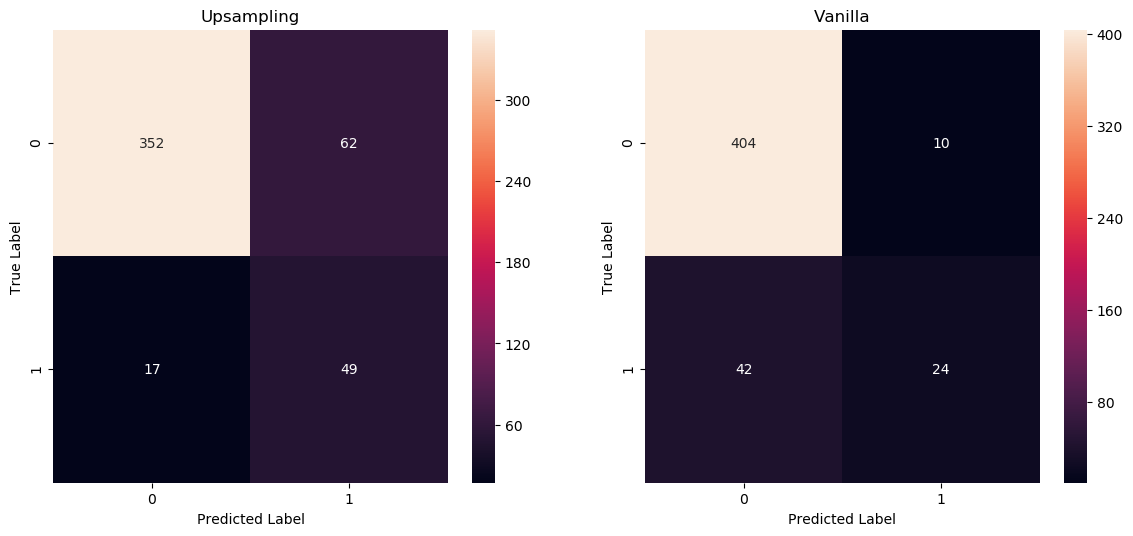

In [19]:
cm = [confusion_matrix(y_test, np.round(pred)) for pred in predictions]

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6), dpi = 100)
sns.heatmap(cm[0], annot = True, fmt = 'd', ax = ax[0])
ax[0].set_title('Upsampling')
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('True Label')

sns.heatmap(cm[1], annot = True, fmt = 'd', ax = ax[1])
ax[1].set_title('Vanilla')
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')

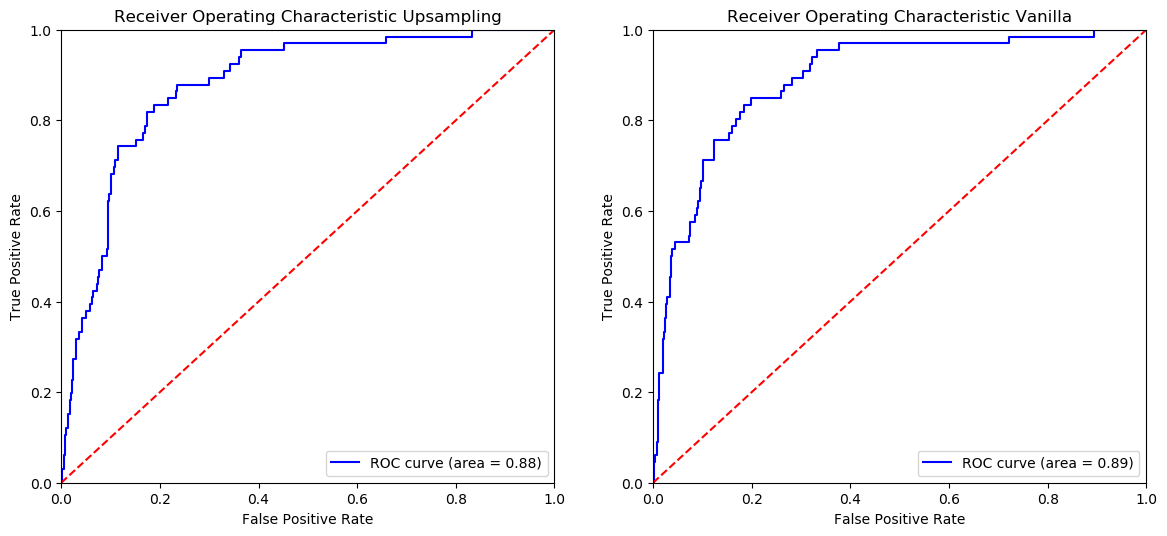

In [20]:
fpr = []
tpr = []
roc_auc = []

for pred in predictions:
    
    current_fpr, current_tpr, _ = roc_curve(y_test, pred)
    current_roc_auc = auc(current_fpr, current_tpr)
    
    fpr.append(current_fpr)
    tpr.append(current_tpr)
    roc_auc.append(current_roc_auc)
    
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6), dpi = 100)
ax[0].set_title('Receiver Operating Characteristic Upsampling')
ax[0].plot(fpr[0], tpr[0], 'b', label = 'ROC curve (area = %0.2f)' % roc_auc[0])
ax[0].legend(loc = 'lower right')
ax[0].plot([0, 1], [0, 1],'r--')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')

ax[1].set_title('Receiver Operating Characteristic Vanilla')
ax[1].plot(fpr[1], tpr[1], 'b', label = 'ROC curve (area = %0.2f)' % roc_auc[1])
ax[1].legend(loc = 'lower right')
ax[1].plot([0, 1], [0, 1],'r--')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

plt.show()

In [ ]:
# fpr_vanilla = []
# tpr_vanilla = []
# roc_auc_vanilla = []
# fpr_vanilla, tpr_vanilla, thresholds_vanilla = roc_curve(y_test, pred_vanilla)
# roc_auc_vanilla = auc(fpr_vanilla, tpr_vanilla)

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr_vanilla, tpr_vanilla, 'b', label = 'ROC curve (area = %0.2f)' % roc_auc_vanilla)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

In [ ]:
# index_numpy_array = np.array(df.index)
# training_set_indices = np.random.choice(index_numpy_array,
#                                         size = int(index_numpy_array.shape[0] * (1-test_size)),
#                                         replace = False)

# test_set_indices = np.delete(index_numpy_array, training_set_indices)
# assert(len(df) == len(training_set_indices) + len(test_set_indices))

# training_set = df.iloc[training_set_indices]
# test_set = df.iloc[test_set_indices]

# print(np.unique(training_set['QUALITY'], return_counts = True))
# print(np.unique(test_set['QUALITY'], return_counts = True))

# """
# Upsampling
#     - since we have a data imbalance between wine qualities, perform upsampling to the minority class,
#       so that the count between the qualities are the same
#     - this is done by sampling from the minority class with replacement
# """
# majority_size_pct = 0.3

# full_training_set_majority_class = training_set[training_set['QUALITY'] != 1].index
# full_training_set_minority_class = training_set[training_set['QUALITY'] == 1].index

# upsampling_training_majority = np.random.choice(full_training_set_majority_class,
#                                                size = int(len(full_training_set_majority_class) * majority_size_pct),
#                                                replace = False
#                                               )
# upsampling_training_minority = np.random.choice(full_training_set_minority_class,
#                                                size = int((len(full_training_set_majority_class) * majority_size_pct) * 1.0),
#                                                replace = True
#                                               )

# upsampling_training_set = df.iloc[np.append(upsampling_training_majority, upsampling_training_minority)]
# upsampling_cross_validation_set = training_set.drop(np.append(upsampling_training_majority, upsampling_training_minority))

# # assert(len(training_set) == len(cross_validation_set_indices) + len(upsampled_training_majority) + len(upsampled_training_minority))

# """
# Downsampling
#     - since we have a data imbalance between wine qualities, perform Downsampling to the minority class,
#       so that the count between the qualities are the same
#     - this is done by subsampling from the majority class without replacement
# """

# majority_size_pct = 0.3

# full_training_set_majority_class = training_set[training_set['QUALITY'] != 1].index
# full_training_set_minority_class = training_set[training_set['QUALITY'] == 1].index

# upsampling_training_majority = np.random.choice(full_training_set_majority_class,
#                                                size = len(full_training_set_minority_class) * 3,
#                                                replace = False
#                                               )
# upsampling_training_minority = np.random.choice(full_training_set_minority_class,
#                                                size = len(full_training_set_minority_class),
#                                                replace = False
#                                               )

# upsampling_training_set = df.iloc[np.append(upsampling_training_majority, upsampling_training_minority)]
# upsampling_cross_validation_set = training_set.drop(np.append(upsampling_training_majority, upsampling_training_minority))

# # assert(len(training_set) == len(cross_validation_set_indices) + len(upsampled_training_majority) + len(upsampled_training_minority))

# y_train = upsampling_training_set['QUALITY'].values
# X_train = upsampling_training_set.drop(columns = ['QUALITY']).values

# y_cross_validation = upsampling_cross_validation_set['QUALITY'].values
# X_cross_validation = upsampling_cross_validation_set.drop(columns = ['QUALITY']).values

# y_test = test_set['QUALITY'].values
# X_test = test_set.drop(columns = ['QUALITY']).values